# DDPG (Deep Deterministic Policy Gradient)

Until now, we applied [policy gradient (on-policy)](./02-policy-gradient.ipynb) in order to handle continuos spaces. (This method then leads to modern [PPO algorithm](./04-ppo.ipynb).)<br>
DDPG (Deep Deterministic Policy Gradient) also apply policy gradient and use Actor-Critic architecture, but it's "deterministic" and it's then called **off-policy**.

After I have introduced DDPG in this notebook, next I'll proceed to more advanced off-policy algorithm, SAC.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

In [ ]:
!pip install torch==1.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install numpy matplotlib

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

Because DDPG cannot operate discrete action space, and here we then use custom CartPole implementation for continuous action space.<br>
The shape of action space in this example is ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)```.

In [2]:
from util.cartpole import CartPole
env = CartPole()

First of all, we will start with the following equation (Bellman equation) discussed in [Q-Learning](./01-q-learning.ipynb) :

$$ Q^{*}(s_t,a_t) = r_t + \gamma \max_a{Q(s_{t+1},a)} \;\;\;\;\;\; (1)$$

where $ Q^{*} $ means the optimal $ Q $ value.

Now we consider Q-network $ Q_{\phi} $ where $\phi$ is parameters.<br>
To optimize the equation (1), we should find $\phi$ to minimize the following loss $L$ for tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \max_a{Q_{\phi}(s_{t+1},a)} \right) \right)^2 \right] \;\;\;\;\;\; (2)$$

where $d_t = 1$ if the episode is done, and $0$ otherwise.

To make the above maximization $\max_a Q_{\phi}(s_{t+1}, a)$ work in continuous action space, we introduce the action policy $\mu_{\theta}(s)$, with which we'll find $\theta$ to maximize $ Q_{\phi}(s, \mu_{\theta}(s)) $.<br>
The equation (2) will then be written as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{\phi}(s_{t+1},\mu_{\theta}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (3) $$

> Note : As you will find, this will again be based on [Actor-Critic method](./03-actor-critic.ipynb) which separates policy ($\mu_{\theta}$) and value evaluation ($Q_{\phi}$) in algorithm.

Please take care for the difference between this policy $\mu_{\theta}(s)$ and a policy used in [on-policy](./02-policy-gradient.ipynb) method. Here $\mu_{\theta}(s)$ is deterministic and it doesn't care how the action space is distributed, unlike $ P(a | \pi_\theta (s)) $ in on-policy methods. (This is because DDPG is called "deterministic" and it's in off-policy method.)

To make the minimization (3) stable, we also introduce the separated parameters $\phi^{\prime}$ and $\theta^{\prime}$ (called **target**) as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{{\phi}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (4) $$

And these parameters are delayed with coefficient parameter (hyper-parameter) $ \tau $ (which is near 0) after each training.

$ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $

$ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

To summarize algorithm :

- Collect tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $
- Optimize $ \phi $ to minimize $L$ in (4)
- Optimize $ \theta $ to maximize $Q_{\phi}(s, \mu_{\theta}(s))$
- Update target parameters as follows
    - $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
    - $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

Now let's start building networks.

(1) Q-network

First, we build Q-network (both $Q_{\phi}(s, a)$ and $Q_{{\phi}^{\prime}}(s, a)$) as follows.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(5, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s, a):
        outs = torch.concat((s, a), dim=-1)
        outs = self.hidden(outs)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

q_origin_model = QNet().to(device)  # Q_phi
q_target_model = QNet().to(device)  # Q_phi'
_ = q_target_model.requires_grad_(False)  # target model doen't need grad

(2) Policy network

Next we build policy network (both $\mu_{\theta}(s)$ and $\mu_{\theta^{\prime}}(s)$) as follows.

As I have mentioned above, action space is ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)``` and it's then activated by ```tanh()```.

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        outs = torch.tanh(outs)
        return outs

mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

(3) Function to optimize network parameters $\phi, \theta$

As I have mentioned above, we optimize parameters as follows :

- Optimize $ \phi $ to minimize $L$ in (4)
- Optimize $ \theta $ to maximize $Q_{\phi}(s, \mu_{\theta}(s))$

In [5]:
gamma = 0.99
opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=0.0005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Optimize critic loss
    opt_q.zero_grad()
    q_org = q_origin_model(states, actions)
    mu_tgt_next = mu_target_model(next_states)
    q_tgt_next = q_target_model(next_states, mu_tgt_next)
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next
    loss_q = F.mse_loss(
        q_org,
        q_tgt,
        reduction="none")
    loss_q.sum().backward()
    opt_q.step()

    # Optimize actor loss
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    for p in q_origin_model.parameters():
        p.requires_grad = False # disable grad in q_origin_model before computation
    q_tgt_max = q_origin_model(states, mu_org)
    (-q_tgt_max).sum().backward()
    opt_mu.step()
    for p in q_origin_model.parameters():
        p.requires_grad = True # enable grad again

(4) Function to update target parameters $\phi^{\prime}, \theta^{\prime}$

Target parameters are updated as follows.

- $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

In [6]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_origin_model.parameters(), q_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

(5) Replay buffer

In on-policy architecture, we fed the sequential samples (trajectory) for each training batch. (See [here](./02-policy-gradient.ipynb).)<br>
To prevent from learning only for recent experiences in DDPG, we store the past experience of tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $ in buffer (called "replay buffer") and pick up the randomized samples in batch training.

In [7]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, batch_size):
        items = random.sample(self.buffer, batch_size)
        states   = [i[0] for i in items]
        actions  = [i[1] for i in items]
        rewards  = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones    = [i[4] for i in items]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(buffer_size=20000)

(6) Noise for exploration

As I mentioned above, the policy $\mu_{\theta}(s)$ is deterministic and it doesn't care how the actions are selected. In order for this reason, the noise will be added for exploration to pick up samples in episode's trials. (If not, this will stuck in the same values forever.)<br>
In DDPG, the following noise (so called [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) noise) is often used.

In [8]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s):
    with torch.no_grad():
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(dim=1)
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        action = np.clip(action, -1.0, 1.0)
        return float(action.item())

(7) Now let's put it all together !

I note that here I train (optimize parameters) in each step, and it might then be slow to step.

In [9]:
batch_size = 250

reward_records = []
for i in range(2000):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, done, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")

Run episode1114 with rewards 500.0
Done


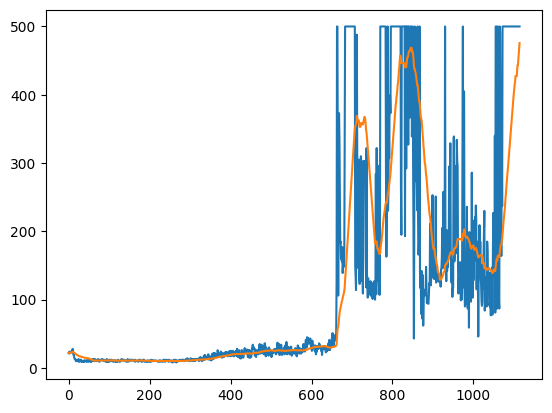

In [10]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

## [Optional] Clipped double-Q learning (Twin-Q)

In advanced algorithms, such as TD3 (Twin Delayed DDPG), 2 Q-networks - $ Q_{\phi_1}(s, a), Q_{\phi_2}(s, a) $ - and corresponding 2 target networks - $ Q_{\phi_1^{\prime}}(s, a), Q_{\phi_2^{\prime}}(s, a) $ - are used to optimize in order to mitigate the risk of overestimation in Q-function.

In this double-Q algorithms, we optimize parameters as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \theta $ to maximize $Q_{\phi_1}(s, \mu_{\theta}(s))$

And update target parameters as follows :

- $ \phi_1^{\prime} = \tau \phi_1 + (1-\tau) \phi_1^{\prime} $
- $ \phi_2^{\prime} = \tau \phi_2 + (1-\tau) \phi_2^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

(1) First, regenerate Q-network and policy network as follows.

In [11]:
q_origin_model1 = QNet().to(device)  # Q_phi1
q_origin_model2 = QNet().to(device)  # Q_phi2
q_target_model1 = QNet().to(device)  # Q_phi1'
q_target_model2 = QNet().to(device)  # Q_phi2'
_ = q_target_model1.requires_grad_(False)  # target model doen't need grad
_ = q_target_model2.requires_grad_(False)  # target model doen't need grad

In [12]:
mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

(2) Regenerate optimize function.

In [13]:
gamma = 0.99
opt_q1 = torch.optim.AdamW(q_origin_model1.parameters(), lr=0.0005)
opt_q2 = torch.optim.AdamW(q_origin_model2.parameters(), lr=0.0005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Compute r + gamma * (1 - done) * min Q (s_next, mu_target(s_next))
    mu_tgt_next = mu_target_model(next_states)
    q1_tgt_next = q_target_model1(next_states, mu_tgt_next)
    q2_tgt_next = q_target_model2(next_states, mu_tgt_next)
    q_tgt_next_min = torch.minimum(q1_tgt_next, q2_tgt_next)
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next_min

    # Optimize critic loss for Q-network1
    opt_q1.zero_grad()
    q1_org = q_origin_model1(states, actions)
    loss_q1 = F.mse_loss(
        q1_org,
        q_tgt,
        reduction="none")
    loss_q1.sum().backward()
    opt_q1.step()

    # Optimize critic loss for Q-network2
    opt_q2.zero_grad()
    q2_org = q_origin_model2(states, actions)
    loss_q2 = F.mse_loss(
        q2_org,
        q_tgt,
        reduction="none")
    loss_q2.sum().backward()
    opt_q2.step()

    # Optimize actor loss
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    for p in q_origin_model1.parameters():
        p.requires_grad = False # disable grad in q_origin_model1 before computation
    q_tgt_max = q_origin_model1(states, mu_org)
    (-q_tgt_max).sum().backward()
    opt_mu.step()
    for p in q_origin_model1.parameters():
        p.requires_grad = True # enable grad again

(3) Regenerate update target's params function.

In [14]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_origin_model1.parameters(), q_target_model1.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(q_origin_model2.parameters(), q_target_model2.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

(4) Let's start training again !

In [15]:
# reset noise
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# reset buffer
buffer = replayBuffer(buffer_size=50000)

# start training
batch_size = 250
reward_records = []
for i in range(5000):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, done, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")

Run episode1088 with rewards 500.0
Done


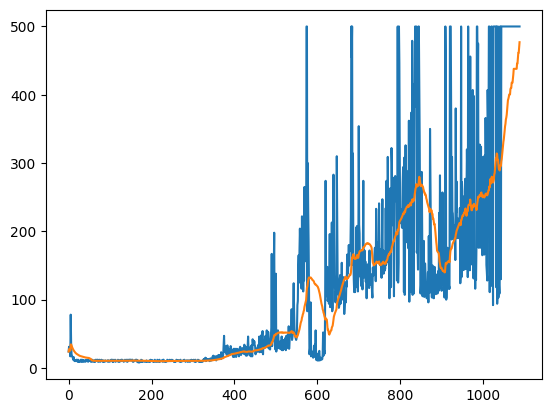

In [16]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)